In [1]:
from pyspark.sql import SQLContext
from pyspark import SparkContext, SparkConf
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
import utils
%matplotlib inline

In [2]:
sc = SparkContext.getOrCreate()##Creación de Spark Context
sqlContext = SQLContext(sc)
df = sqlContext.read.load('minute_weather.csv', format='com.databricks.spark.csv', header='true',inferSchema='true')

In [3]:
df.count()

1587257

In [4]:
filteredDF = df.filter((df.rowID % 10) == 0)
filteredDF.count()

158726

In [5]:
filteredDF.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
rowID,158726,793625.0,458203.9375103623,0,1587250
air_pressure,158726,916.8301614102413,3.051716552830777,905.0,929.5
air_temp,158726,61.851589153636084,11.833569210641707,31.64,99.5
avg_wind_direction,158680,162.15610032770354,95.27820101905918,0.0,359.0
avg_wind_speed,158680,2.7752148979077367,2.057623969742644,0.0,31.9
max_wind_direction,158680,163.46214393748426,92.45213853838698,0.0,359.0
max_wind_speed,158680,3.400557726241551,2.4188016208098855,0.1,36.0
min_wind_direction,158680,166.77401688933702,97.44110914784568,0.0,359.0
min_wind_speed,158680,2.134664103856835,1.742112505242438,0.0,31.6


In [6]:
filteredDF.filter(filteredDF.rain_accumulation == 0.0).count() 

157812

In [7]:
filteredDF.filter(filteredDF.rain_duration == 0.0).count() 

157237

In [8]:
workingDF = filteredDF.drop('rain_accumulation').drop('rain_duration').drop('hpwren_timestamp')

In [9]:
before = workingDF.count()
workingDF = workingDF.na.drop()
after = workingDF.count()
before - after

46

In [10]:
workingDF.columns

['rowID',
 'air_pressure',
 'air_temp',
 'avg_wind_direction',
 'avg_wind_speed',
 'max_wind_direction',
 'max_wind_speed',
 'min_wind_direction',
 'min_wind_speed',
 'relative_humidity']

Se transforma el conjunto de columnas a un vector, adicionando una columna llamada "features_unscaled"

In [11]:
featuresUsed = ['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 
        'max_wind_speed','relative_humidity']
assembler = VectorAssembler(inputCols=featuresUsed, outputCol="features_unscaled")
assembled = assembler.transform(workingDF)

In [12]:
assembled.toPandas().head()

,rowID,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,relative_humidity,features_unscaled
0,0,912.3,64.76,97.0,1.2,106.0,1.6,85.0,1.0,60.5,"[912.3, 64.76, 97.0, 1.2, 106.0, 1.6, 60.5]"
1,10,912.3,62.24,144.0,1.2,167.0,1.8,115.0,0.6,38.5,"[912.3, 62.24, 144.0, 1.2, 167.0, 1.8, 38.5]"
2,20,912.2,63.32,100.0,2.0,122.0,2.5,91.0,1.5,58.3,"[912.2, 63.32, 100.0, 2.0, 122.0, 2.5, 58.3]"
3,30,912.2,62.60,91.0,2.0,103.0,2.4,71.0,1.4,57.9,"[912.2, 62.6, 91.0, 2.0, 103.0, 2.4, 57.9]"
4,40,912.2,64.04,81.0,2.6,88.0,2.9,68.0,1.4,57.4,"[912.2, 64.04, 81.0, 2.6, 88.0, 2.9, 57.4]"


Se toma la columna de salida del paso anterior y se pasa por la función de escalamiento dando como resultado el dataframe escalado (scaledData) y una columna adicional "features".

In [13]:
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=True)
scalerModel = scaler.fit(assembled)
scaledData = scalerModel.transform(assembled)

In [14]:
type(scaledData)

pyspark.sql.dataframe.DataFrame

In [15]:
scaledData.toPandas().head()

,rowID,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,relative_humidity,features_unscaled,features
0,0,912.3,64.76,97.0,1.2,106.0,1.6,85.0,1.0,60.5,"[912.3, 64.76, 97.0, 1.2, 106.0, 1.6, 60.5]","[-1.4845581289534042, 0.24544378081470336, -0...."
1,10,912.3,62.24,144.0,1.2,167.0,1.8,115.0,0.6,38.5,"[912.3, 62.24, 144.0, 1.2, 167.0, 1.8, 38.5]","[-1.4845581289534042, 0.03247132094666655, -0...."
2,20,912.2,63.32,100.0,2.0,122.0,2.5,91.0,1.5,58.3,"[912.2, 63.32, 100.0, 2.0, 122.0, 2.5, 58.3]","[-1.5173268866687695, 0.12374523231868208, -0...."
3,30,912.2,62.60,91.0,2.0,103.0,2.4,71.0,1.4,57.9,"[912.2, 62.6, 91.0, 2.0, 103.0, 2.4, 57.9]","[-1.5173268866687695, 0.06289595807067172, -0...."
4,40,912.2,64.04,81.0,2.6,88.0,2.9,68.0,1.4,57.4,"[912.2, 64.04, 81.0, 2.6, 88.0, 2.9, 57.4]","[-1.5173268866687695, 0.18459450656669302, -0...."


In [16]:
scaledData = scaledData.select("features", "rowID")
scaledData.toPandas().head()

,features,rowID
0,"[-1.4845581289534042, 0.24544378081470336, -0....",0
1,"[-1.4845581289534042, 0.03247132094666655, -0....",10
2,"[-1.5173268866687695, 0.12374523231868208, -0....",20
3,"[-1.5173268866687695, 0.06289595807067172, -0....",30
4,"[-1.5173268866687695, 0.18459450656669302, -0....",40


Muestreo para reducir tiempo computacional

In [17]:
elbowset = scaledData.filter((scaledData.rowID % 3) == 0).select("features")

This line calls the persist() method to tell Spark to keep the data in memory (if possible), which will speed up the computations.

In [18]:
elbowset.persist()

DataFrame[features: vector]

In [19]:
clusters = range(2,31)
wsseList = utils.elbow(elbowset, clusters)

Training for cluster size 2 
......................WSSE = 116109.01056064 
Training for cluster size 3 
......................WSSE = 102466.3686646405 
Training for cluster size 4 
......................WSSE = 95150.27318353434 
Training for cluster size 5 
......................WSSE = 88050.25741790982 
Training for cluster size 6 
......................WSSE = 84748.47655560053 
Training for cluster size 7 
......................WSSE = 81557.33185826501 
Training for cluster size 8 
......................WSSE = 78739.7998190601 
Training for cluster size 9 
......................WSSE = 77505.93111475557 
Training for cluster size 10 
......................WSSE = 75040.95565528862 
Training for cluster size 11 
......................WSSE = 72981.95485726686 
Training for cluster size 12 
......................WSSE = 70881.009344507 
Training for cluster size 13 
......................WSSE = 68518.26363991346 
Training for cluster size 14 
......................WSSE = 67870.53885171485 

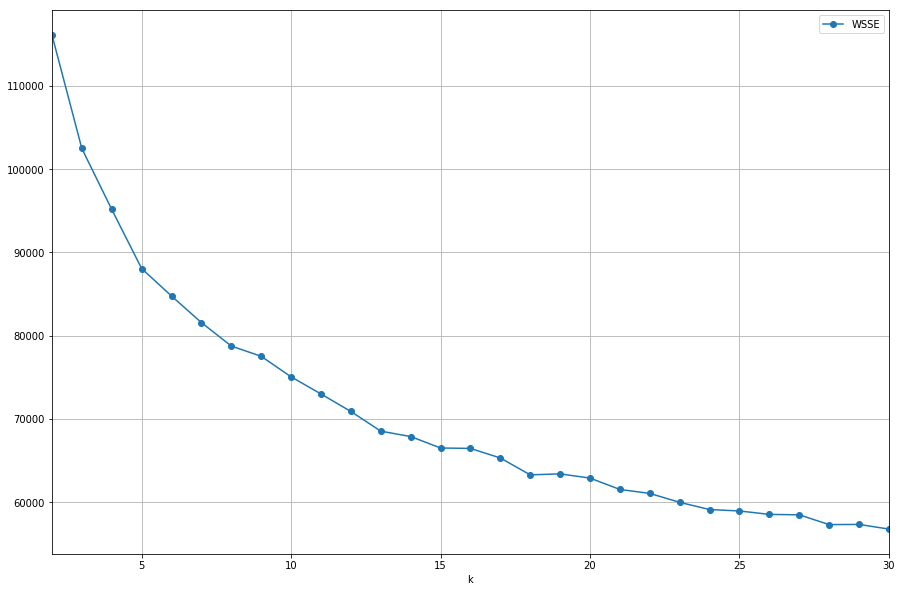

In [20]:
utils.elbow_plot(wsseList, clusters)

In [21]:
scaledDataFeat = scaledData.select("features")
scaledDataFeat.persist()

DataFrame[features: vector]

The first line creates a new KMeans instance with 12 clusters and a specific seed value. (As in previous hands-on activities, we use a specific seed value for reproducible results.) The second line fits the data to the model, and the third applies the model to the data.

In [22]:
kmeans = KMeans(k=12, seed=1)
model = kmeans.fit(scaledDataFeat)
transformed = model.transform(scaledDataFeat)

In [23]:
type(model)

pyspark.ml.clustering.KMeansModel

In [24]:
type(transformed)

pyspark.sql.dataframe.DataFrame

In [25]:
centers = model.clusterCenters()
centers

[array([-0.1894305 ,  0.6336656 ,  0.40812551,  0.7028227 ,  0.51685827,
         0.64267099, -0.17969439]),
 array([-0.17700328,  0.84982085, -1.30857278, -0.58967569, -1.16572019,
        -0.60551295, -0.62539862]),
 array([-0.94119796, -0.0595349 ,  0.11493142, -0.5580438 ,  0.28680116,
        -0.56433045,  0.46869052]),
 array([-0.75850832, -1.25455264,  0.39049733,  0.45709322,  0.48598457,
         0.44231462,  1.39434095]),
 array([ 0.38881407, -1.02954842,  0.71186067, -0.5258618 ,  0.90236313,
        -0.50601962,  1.12384539]),
 array([ 1.18890702, -0.25486292, -1.15481227,  2.11669659, -1.05316641,
         2.23335782, -1.13411658]),
 array([ 0.18099636,  0.78614769,  1.42055673, -0.63557071,  1.68514046,
        -0.58571315, -0.72209781]),
 array([ 0.15477596, -0.82596751, -1.22092607, -0.55981644, -1.07067287,
        -0.57487011,  0.88308784]),
 array([ 0.23801187,  0.32310376,  1.88857352, -0.65158935, -1.55127501,
        -0.5764758 , -0.28659837]),
 array([ 0.18709797

In [26]:
P = utils.pd_centers(featuresUsed, centers)

## Dry Days

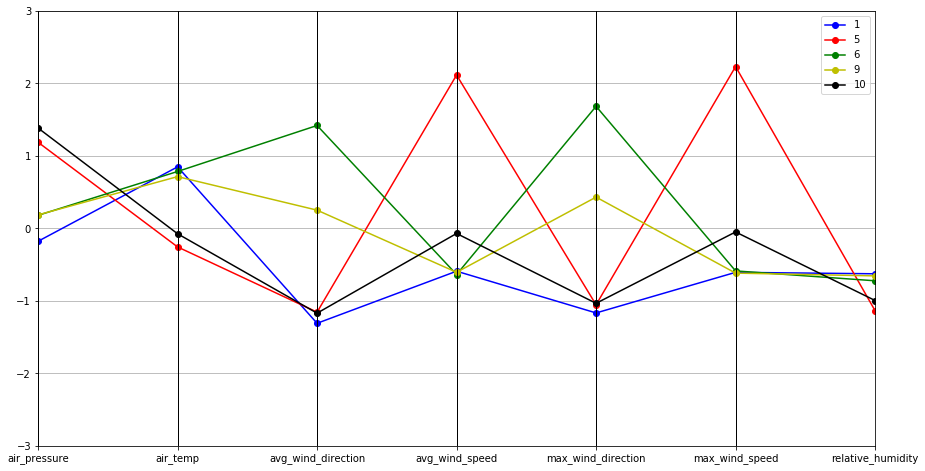

In [27]:
utils.parallel_plot(P[P['relative_humidity'] < -0.5], P)

## Warm Days

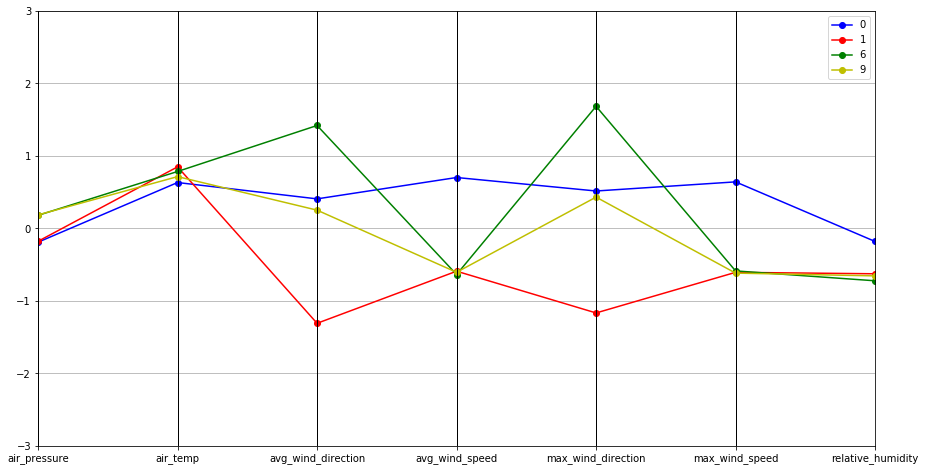

In [28]:
utils.parallel_plot(P[P['air_temp'] > 0.5], P)

## Cool Days

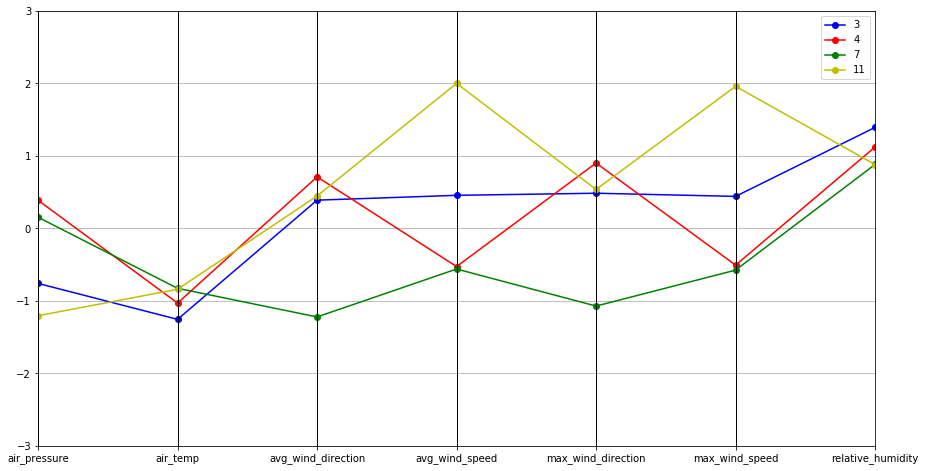

In [29]:
utils.parallel_plot(P[(P['relative_humidity'] > 0.5) & (P['air_temp'] < 0.5)], P)

## Other Days

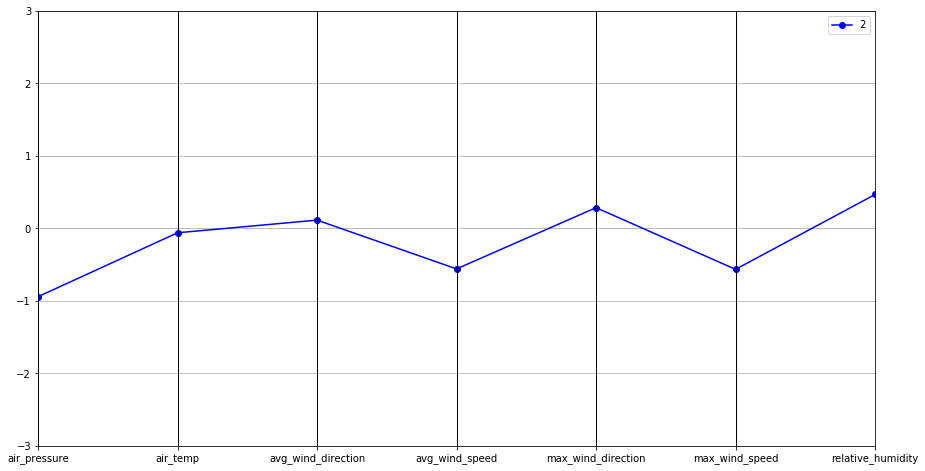

In [30]:
utils.parallel_plot(P.iloc[[2]], P)